In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm import tqdm

from astropy.io import fits
import fitsio

In [2]:
import lightkurve as lk
from scipy import stats
from astropy.time import Time
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
from astropy.visualization import simple_norm

In [3]:
from roman_lcs import Machine, RomanMachine

In [4]:
PATH = "/Users/jimartin/Work/ROMAN/simulations/run_v0.2"

In [5]:
ff = sorted(os.listdir(f"{PATH}/imgs"))
ff = [f"{PATH}/imgs/{x}" for x in ff]
len(ff)

6702

In [172]:
ff[0]

'/Users/jimartin/Work/ROMAN/simulations/run_v0.2/imgs/rimtimsim_WFI_rampfitted_F146_SCA01_field01_ramp_subframe_0250x0250_20270214T0013_sim.fits'

In [7]:
catalog = pd.read_csv(f"{PATH}/mean_input_catalog.txt", index_col=0)
catalog["flux"] = 10 ** ((27.53861667037689 - catalog["F146"])/2.5)
catalog["flux_err"] = np.sqrt(catalog["flux"])
catalog

sicbroid        xcol        ycol    F146      ra_deg    dec_deg  \
-1             0  125.000000  125.000000  17.000  268.279268 -28.746497   
 0             1  175.281640  217.529604  20.717  268.282355 -28.744864   
 1             2   69.039869  140.004071  24.701  268.277838 -28.745248   
 2             3   24.095405   52.197116  23.149  268.274992 -28.746840   
 3             4  151.019019  217.089188  23.617  268.281617 -28.744503   
...          ...         ...         ...     ...         ...        ...   
 18545     18546   49.219505   94.403485  24.868  268.276466 -28.746129   
 18546     18547    2.039745  110.334565  25.123  268.275317 -28.744991   
 18547     18548   91.446810   21.156735  24.298  268.276492 -28.748681   
 18548     18549  194.216412   91.312406  23.769  268.280779 -28.748435   
 18549     18550  227.218897   32.953026  22.647  268.280781 -28.750458   

                flux    flux_err  
-1      16422.779737  128.151394  
 0        535.360923   23.137868  
 1         13.647298    3.694225  
 2         56.996301    7.549589  
 3         37.037927    6.085879  
...              ...         ...  
 18545     11.701638    3.420766  
 18546      9.252235    3.041749  
 18547     19.780928    4.447576  
 18548     32.199318    5.674444  
 18549     90.499602    9.513128  

[18551 rows x 8 columns]

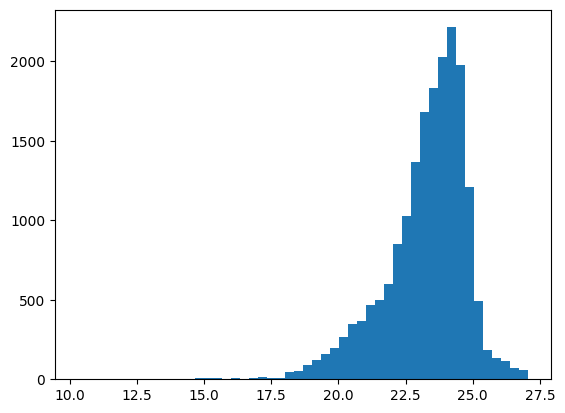

In [8]:
plt.hist(catalog.F146, bins=50)
plt.show()

In [9]:
sources = catalog.query("F146 < 23 and xcol < 125 and ycol < 125").reset_index(drop=False)
sources = sources.rename(columns={"ra_deg": "ra", "dec_deg": "dec", "xcol": "column", "ycol": "row"})
sources

index  sicbroid      column         row    F146          ra        dec  \
0         5         6  122.235858  103.414587  22.325  268.278818 -28.747016   
1         9        10  113.863971   38.416981  22.769  268.277461 -28.748576   
2        25        26   73.508688   70.789083  21.370  268.276796 -28.747116   
3        49        50   63.489769  116.298000  20.540  268.277268 -28.745779   
4        57        58   42.691577   67.477044  22.968  268.275812 -28.746729   
...     ...       ...         ...         ...     ...         ...        ...   
1636  18489     18490   15.600171   16.939932  22.897  268.274137 -28.747626   
1637  18494     18495   92.024457   49.815301  21.003  268.276997 -28.747945   
1638  18506     18507   10.192706   91.303237  19.849  268.275238 -28.745611   
1639  18521     18522   31.421805   57.219752  21.513  268.275298 -28.746822   
1640  18527     18528   75.695859   81.331508  21.002  268.277041 -28.746875   

             flux   flux_err  
0      121.743748  11.033755  
1       80.881029   8.993388  
2      293.390919  17.128658  
3      630.153958  25.102868  
4       67.335900   8.205845  
...           ...        ...  
1636    71.886389   8.478584  
1637   411.383310  20.282586  
1638  1190.821503  34.508282  
1639   257.185612  16.037008  
1640   411.762383  20.291929  

[1641 rows x 9 columns]

# PSFMachine

## Build PRF mdoel with full data and $mag < 21$

In [266]:
sources = catalog.query("F146 < 21").reset_index(drop=False)
sources = sources.rename(columns={"ra_deg": "ra", "dec_deg": "dec", "xcol": "column", "ycol": "row"})
sources

index  sicbroid      column         row    F146          ra        dec  \
0        -1         0  125.000000  125.000000  17.000  268.279268 -28.746497   
1         0         1  175.281640  217.529604  20.717  268.282355 -28.744864   
2         4         5  208.192458   79.438460  19.243  268.280998 -28.748958   
3        24        25  193.979337  105.265561  20.793  268.281009 -28.748069   
4        31        32  225.556490   69.568893  20.910  268.281353 -28.749481   
...     ...       ...         ...         ...     ...         ...        ...   
1693  18465     18466  155.160154   30.841295  20.751  268.278575 -28.749407   
1694  18479     18480  179.040602   73.442134  20.845  268.280018 -28.748666   
1695  18481     18482  126.902694  152.644854  15.671  268.279795 -28.745808   
1696  18506     18507   10.192706   91.303237  19.849  268.275238 -28.745611   
1697  18522     18523   65.212106  145.816187  19.722  268.277822 -28.745038   

              flux    flux_err  
0     16422.779737  128.151394  
1       535.360923   23.137868  
2      2080.878237   45.616644  
3       499.167922   22.342066  
4       448.174010   21.170121  
...            ...         ...  
1693    518.855791   22.778406  
1694    475.824356   21.813399  
1695  55853.020971  236.332437  
1696   1190.821503   34.508282  
1697   1338.587201   36.586708  

[1698 rows x 9 columns]

In [267]:
mac = RomanMachine.from_file(
    ff[:1], 
    sources=sources,
    sparse_dist_lim=2, 
    sources_flux_column="flux",
    cutout_size=None,
    cutout_origin=[0, 0],
)
mac.contaminant_flux_limit = 10 ** ((27.648 - 21)/2.5)
mac

Creating delta arrays: 100%|██████████████████████████████████████████████████████████| 1698/1698 [00:00<00:00, 2626.17it/s]


RomanMachine (N sources, N times, N pixels): (1698, 1, 62500)

In [268]:
mac.image_shape

(250, 250)

<WCSAxes: label='overlays', title={'center': 'Roman-Sim | SCA01 | F146\nFrame 0 | JD 2461450.5094267055 '}>

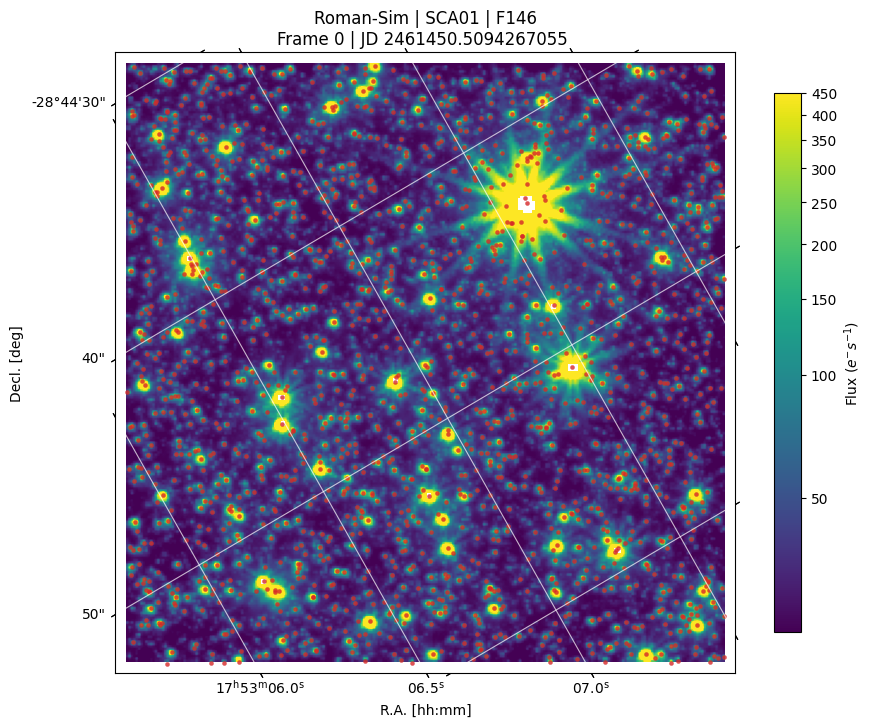

In [269]:
mac.plot_image(sources=True, frame_index=0)

In [270]:
examples = np.random.choice(mac.sources.query("F146 < 19").index.values, size=7*7)
examples

array([  63, 1031, 1393, 1548,  626, 1523,  244,  560, 1225,  210,  832,
       1315,  444,  663,  314,  461, 1586,  985, 1299,  942,  150,  634,
        466, 1124,  780, 1169,  211, 1523,  325,  255, 1560,  157,  546,
       1046,  823,  788,  749, 1287,  774,  449,  874,  795,  622, 1225,
        167, 1550,  971,  323,  167])

Creating delta arrays: 100%|██████████████████████████████████████████████████████████| 1698/1698 [00:00<00:00, 2840.39it/s]
/Users/jimartin/miniforge3/envs/roman/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1562: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


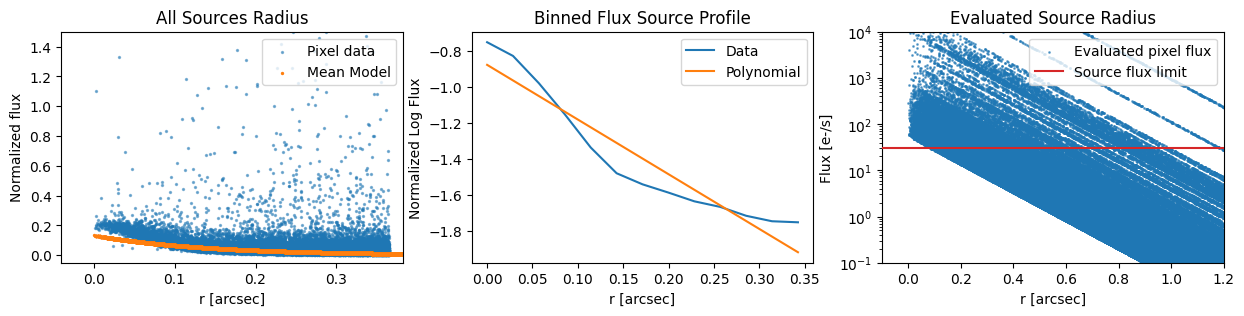

In [271]:
mac._get_source_mask(source_flux_limit=30, plot=True, reference_frame=0, iterations=1)

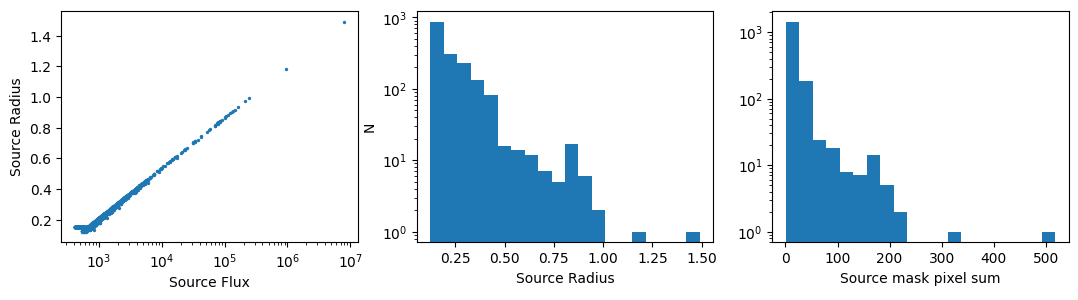

In [272]:
fig, ax = plt.subplots(1, 3, figsize=(13, 3))

ax[0].scatter(mac.sources.flux, mac.radius, s=2)
ax[0].set_xlabel("Source Flux")
ax[0].set_ylabel("Source Radius")
ax[0].set_xscale("log")

ax[1].hist(mac.radius, bins=20)
ax[1].set_xlabel("Source Radius")
ax[1].set_ylabel("N")
ax[1].set_yscale("log")

ax[2].hist(np.array(mac.source_mask.sum(axis=1)).ravel(), bins=20)
ax[2].set_xlabel("Source mask pixel sum")
ax[2].set_yscale("log")

plt.show()

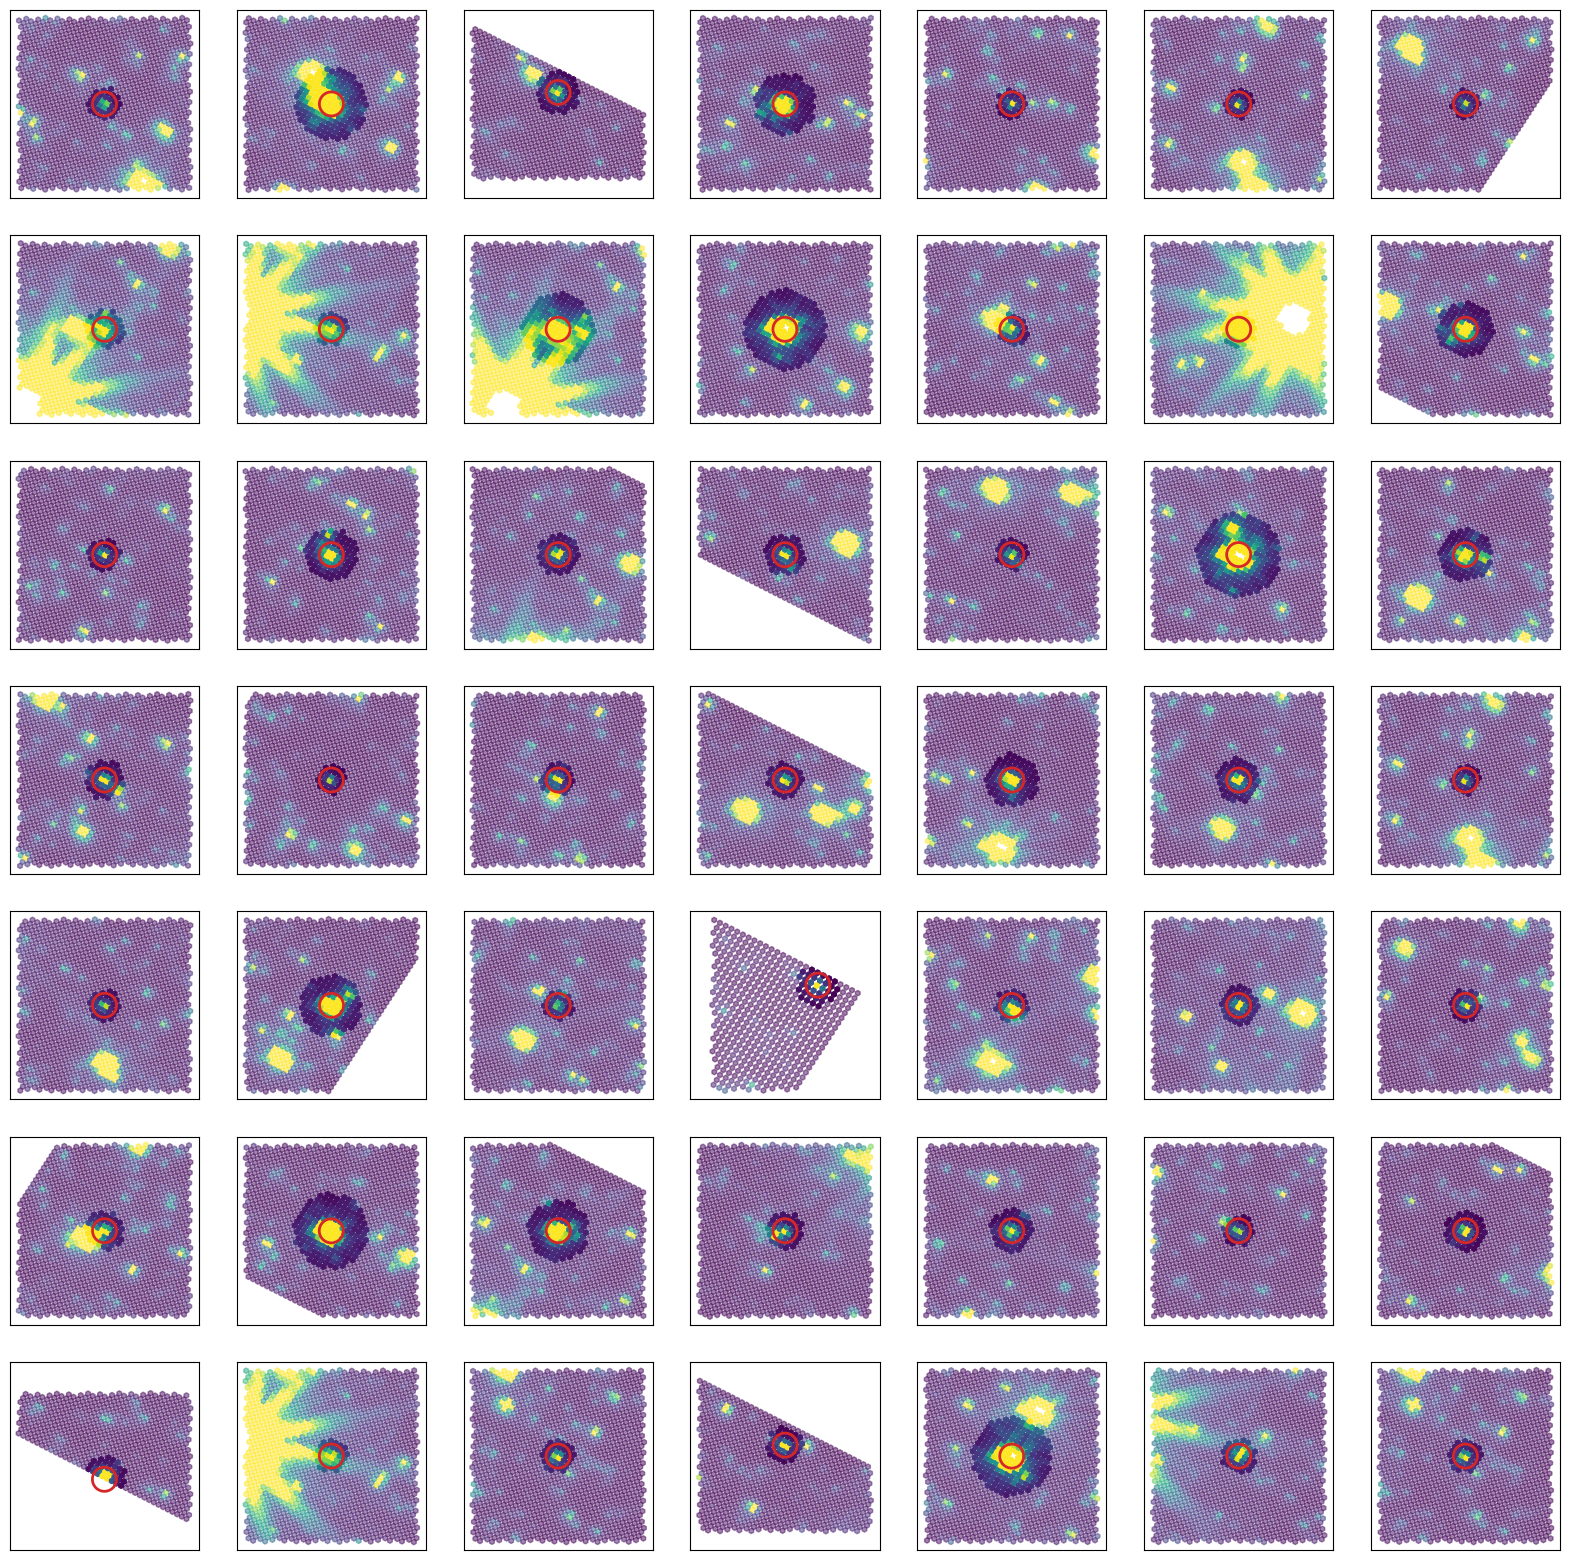

In [273]:
flux_masked = mac.r.astype(bool).multiply(mac.flux[0]).tocsr()

source_mask_dx = mac.source_mask.multiply(mac.dra).tocsr()
source_mask_dy = mac.source_mask.multiply(mac.ddec).tocsr()
source_mask_flux = mac.source_mask.multiply(mac.flux[0]).tocsr()

fig, ax = plt.subplots(7, 7, figsize=(20,20))

for i, k in enumerate(examples):
    ax.ravel()[i].scatter(mac.dra[k].data*3600, 
                          mac.ddec[k].data*3600, 
                          s=15, marker="h", 
                          c=flux_masked[k].data, 
                          alpha=0.5,
                          vmin=10, vmax=500)
    ax.ravel()[i].scatter(source_mask_dx[k].data*3600, 
                          source_mask_dy[k].data*3600, 
                          s=15, marker="h", 
                          c=source_mask_flux[k].data, 
                          alpha=1,
                          vmin=10, vmax=500)
    ax.ravel()[i].scatter(0, 0, s=300, edgecolor="tab:red", marker="o", facecolor="none", lw=2)
    ax.ravel()[i].axis('equal')
    ax.ravel()[i].set_xticks([])
    ax.ravel()[i].set_yticks([])
plt.show()

In [274]:
mac.rough_mask

<Compressed Sparse Row sparse matrix of dtype 'bool'
	with 52048 stored elements and shape (1698, 62500)>

In [275]:
mac.source_mask, mac.uncontaminated_source_mask

(<Compressed Sparse Row sparse matrix of dtype 'bool'
 	with 29659 stored elements and shape (1698, 62500)>,
 <Compressed Sparse Row sparse matrix of dtype 'bool'
 	with 18258 stored elements and shape (1698, 62500)>)

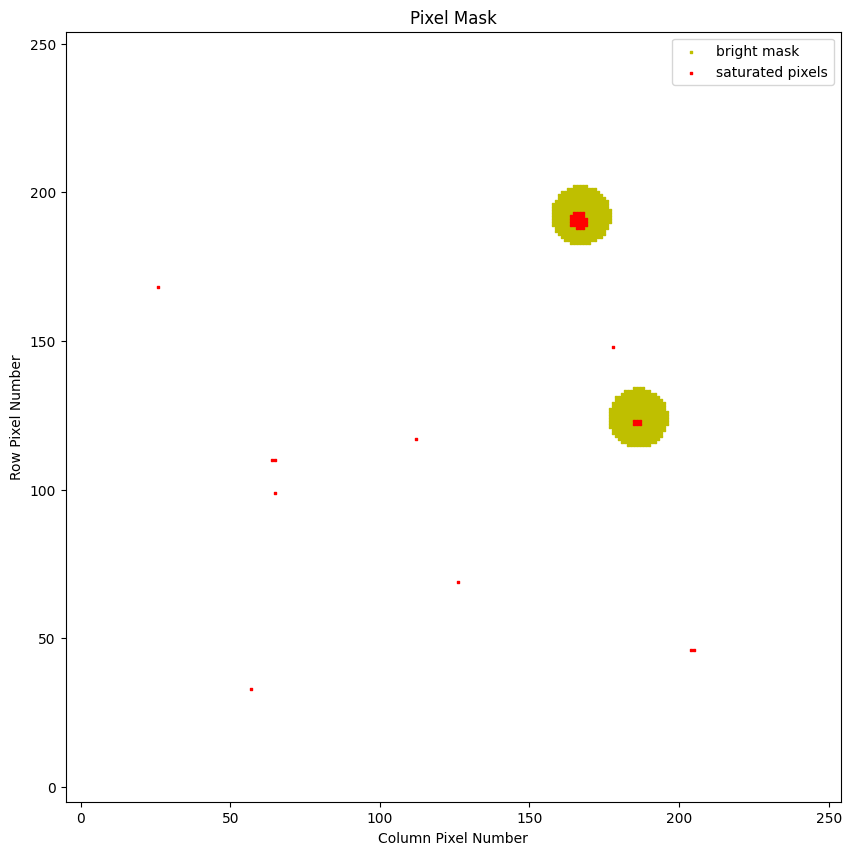

In [276]:
# mac._mask_pixels(magnitude_bright_limit=13)
_ = mac.plot_pixel_masks()

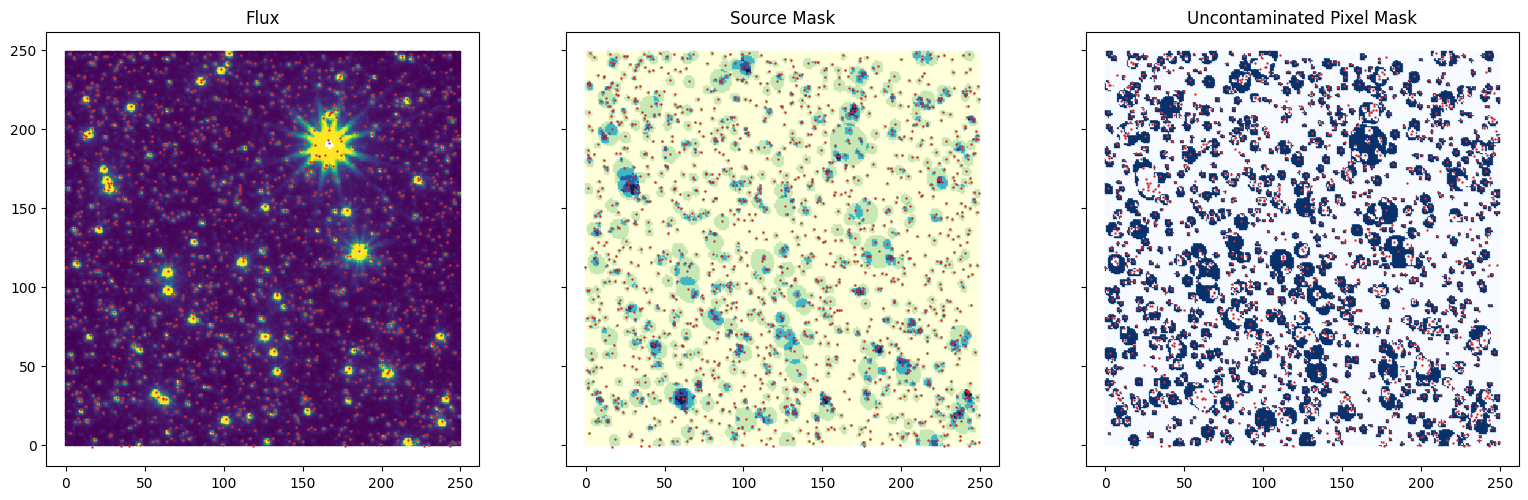

In [277]:
# mac._update_source_mask(frame_index=mac.ref_frame)
ROW, COL = mac.pixel_coordinates(mac.ref_frame)

fig, ax = plt.subplots(1, 3, figsize=(19, 9), sharex=True, sharey=True)

ax[0].set_title("Flux")
ax[0].scatter(
    mac.column,
    mac.row,
    c=mac.flux[mac.ref_frame], 
    vmin=10, 
    vmax=500,
    s=1,
    marker="s",
)
ax[0].scatter(COL, ROW, c="tab:red", marker=".", s=2)

ax[1].set_title("Source Mask")
ax[1].scatter(
    mac.column,
    mac.row,
    c=np.array(mac.source_mask.sum(axis=0)[0]), 
    vmin=0, 
    vmax=4,
    alpha=1,
    cmap="YlGnBu",
    s=1,
    marker="s",
)
ax[1].scatter(COL, ROW, c="tab:red", marker=".", s=2)

ax[2].set_title("Uncontaminated Pixel Mask")
ax[2].scatter(
    mac.column,
    mac.row,
    c=np.array(mac.uncontaminated_source_mask.sum(axis=0)[0]), 
    vmin=0, 
    vmax=1,
    alpha=1,
    cmap="Blues",
    s=1,
    marker="s",
)
ax[2].scatter(COL, ROW, c="tab:red", marker=".", s=2)

ax[0].set_aspect("equal", adjustable="box")
ax[1].set_aspect("equal", adjustable="box")
ax[2].set_aspect("equal", adjustable="box")

plt.show()

Creating delta arrays: 100%|██████████████████████████████████████████████████████████| 1698/1698 [00:00<00:00, 2852.05it/s]
/Users/jimartin/miniforge3/envs/roman/lib/python3.10/site-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


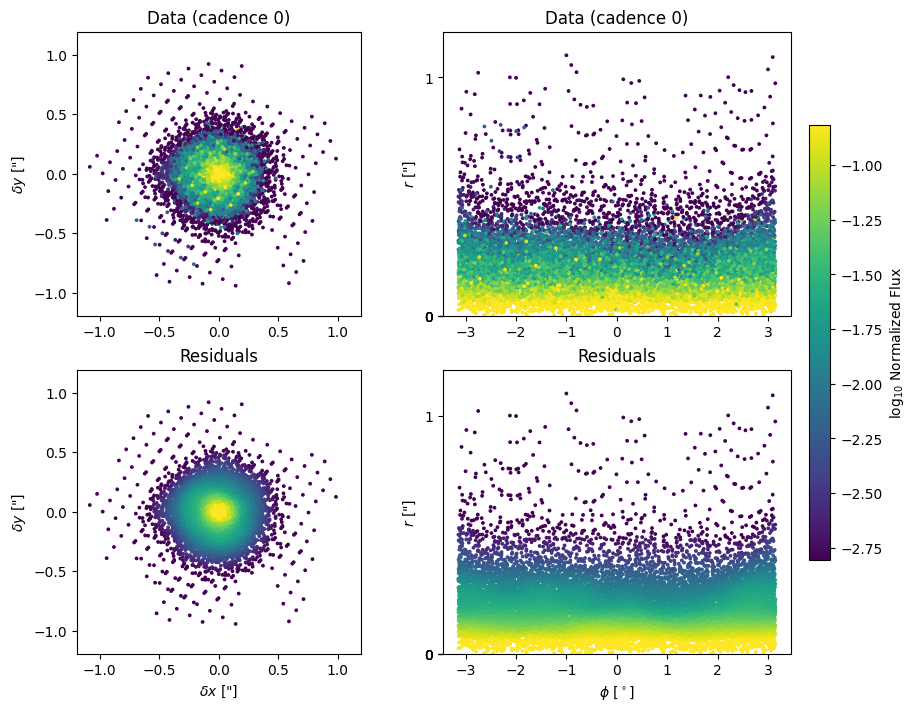

In [278]:
mac.rmin = 0.02
mac.rmax = 0.8
mac.cut_r = 0.2
mac.n_r_knots = 9
mac.n_phi_knots = 15
psf_tdx = 0

mac.build_shape_model(
    plot=True,
    flux_cut_off=0.2,
    frame_index=psf_tdx,
    bin_data=False,
)
plt.show()

In [279]:
output = f"./data/roman_WFI_{mac.meta['READMODE']}_{mac.meta['FILTER']}_{mac.meta['DETECTOR']}_shape_model_cad{psf_tdx}.fits"
mac.save_shape_model(output=output)

In [299]:
mac.fit_model()

Fitting 1698 Sources (w. VA):   0%|                                                                   | 0/1 [00:00<?, ?it/s]
 ... (more hidden) ...
 ... (more hidden) ...
 ... (more hidden) ...
 ... (more hidden) ...
 ... (more hidden) ...
Fitting 1698 Sources (w. VA): 100%|███████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.33s/it]


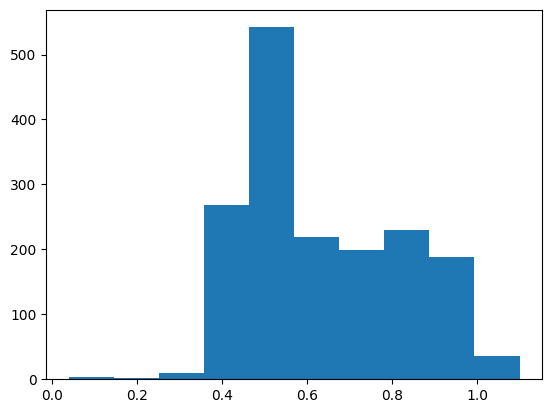

In [300]:
plt.hist(np.array(mac.mean_model.sum(axis=1)));

In [301]:
mac.ws

array([[nan, nan, nan, ..., nan, nan, nan]])

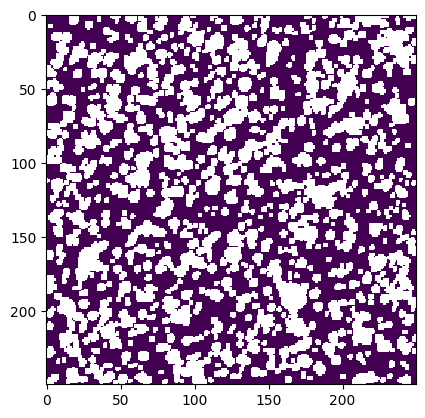

In [302]:
plt.imshow(mac.model_flux[0].reshape(mac.image_shape));

In [307]:
prior_sigma = (
            np.ones(mac.mean_model.shape[0])
            * 5
            * np.abs(mac.source_flux_estimates) ** 0.5
        )
prior_sigma

array([ 640.75696908,  115.68933866,  228.0832215 , ..., 1181.66218704,
        172.54140828,  182.93353991])

In [304]:
mac.source_flux_estimates

array([16422.77973715,   535.36092314,  2080.87823711, ...,
       55853.02097098,  1190.8215028 ,  1338.58720101])

In [312]:
mac.mean_model[0].data

array([0.00394374, 0.00434721, 0.00318674, 0.00671803, 0.01161179,
       0.01305963, 0.00948339, 0.00415257, 0.00366072, 0.00823197,
       0.02018487, 0.02881758, 0.03134992, 0.02209908, 0.00824441,
       0.00394467, 0.01505214, 0.02885072, 0.09062711, 0.09443305,
       0.02812208, 0.01106267, 0.00354823, 0.01564522, 0.03586306,
       0.13229989, 0.12520743, 0.02500134, 0.00861675, 0.00269627,
       0.00898372, 0.01970046, 0.03410979, 0.02976803, 0.01464902,
       0.005497  , 0.00433922, 0.00879108, 0.01126203, 0.00974851,
       0.00656313, 0.00274892, 0.00413539, 0.00412924, 0.00387744,
       0.00300339])

In [332]:
mac.source_mask.multiply(mac.flux[0])

<COOrdinate sparse matrix of dtype 'float64'
	with 23698 stored elements and shape (1698, 62500)>

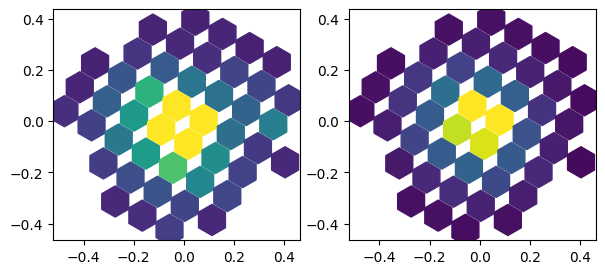

In [338]:
idx = 0



dx = mac.source_mask.multiply(mac.dra)[idx].data
dy = mac.source_mask.multiply(mac.ddec)[idx].data
data = mac.source_mask.multiply(mac.flux[0]).tocsr()[idx].data
model = mac.mean_model[idx].data

fig, ax = plt.subplots(1, 2, figsize=(7,3))
ax[0].scatter(dx*3600, dy*3600, c=data, vmin=0, vmax=600, marker="h", s=500)
ax[1].scatter(dx*3600, dy*3600, c=model, vmin=0, vmax=0.1, marker="h", s=500)
plt.show()

## Evaluate Model on substamp with full catalog

In [195]:
sources = catalog.query("F146 < 21 and xcol < 125 and ycol < 125").reset_index(drop=False)
sources = sources.rename(columns={"ra_deg": "ra", "dec_deg": "dec", "xcol": "column", "ycol": "row"})
sources

index  sicbroid      column         row    F146          ra        dec  \
0       49        50   63.489769  116.298000  20.540  268.277268 -28.745779   
1       78        79    7.087752   33.925925  20.294  268.274170 -28.747054   
2      125       126   26.668413   73.090598  19.524  268.275425 -28.746337   
3      140       141    6.078032   81.631765  20.742  268.274950 -28.745799   
4      163       164   60.019046   85.345578  18.970  268.276637 -28.746530   
..     ...       ...         ...         ...     ...         ...        ...   
428  18342     18343  109.890847   84.309916  20.512  268.278121 -28.747323   
429  18372     18373   78.476191   33.082384  20.534  268.276305 -28.748172   
430  18390     18391    7.149210  123.266759  20.972  268.275690 -28.744733   
431  18422     18423   27.478701  109.797793  20.147  268.276073 -28.745395   
432  18506     18507   10.192706   91.303237  19.849  268.275238 -28.745611   

            flux   flux_err  
0     630.153958  25.102868  
1     790.399521  28.114045  
2    1606.374007  40.079596  
3     523.174621  22.873011  
4    2675.756987  51.727720  
..           ...        ...  
428   646.616330  25.428652  
429   633.645957  25.172325  
430   423.298440  20.574218  
431   904.996018  30.083152  
432  1190.821503  34.508282  

[433 rows x 9 columns]

In [225]:
mac = RomanMachine.from_file(
    ff[:100], 
    sources=sources,
    sparse_dist_lim=2, 
    sources_flux_column="flux",
    cutout_size=125,
    cutout_origin=[0, 0],
)
mac.contaminant_flux_limit = 10 ** ((27.648 - 21)/2.5)
mac

100%|████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 231.68it/s]


RomanMachine (N sources, N times, N pixels): (433, 100, 15625)

In [226]:
mac.image_shape

(125, 125)

<WCSAxes: label='overlays', title={'center': 'Roman-Sim | SCA01 | F146\nFrame 0 | JD 2461450.5094267055 '}>

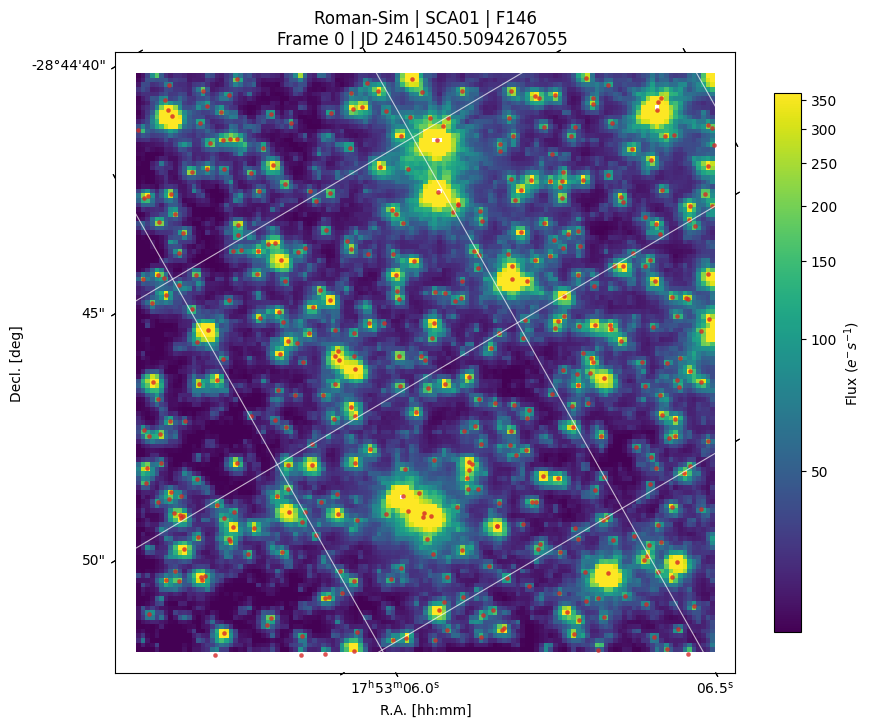

In [227]:
mac.plot_image(sources=True)

In [228]:
mac.meta

{'MISSION': 'Roman-Sim',
 'TELESCOP': 'Roman',
 'RADESYS': 'FK5',
 'EQUINOX': 2000.0,
 'FILTER': 'F146',
 'FIELD': 1,
 'DETECTOR': 'SCA01',
 'EXPOSURE': 57.0,
 'READMODE': 'ramp'}

In [239]:
mac.r

<Quantity [[15.65105873, 15.58108626, 15.51175229, ...,  7.36097129,
             7.48150229,  7.60206923],
           [ 3.80942803,  3.77320223,  3.74058415, ..., 18.23882578,
            18.33997076, 18.44136361],
           [ 8.93866566,  8.8843    ,  8.8312757 , ..., 13.59531009,
            13.70539707, 13.81567818],
           ...,
           [13.73820678, 13.71861115, 13.70006784, ..., 14.06393357,
            14.1855753 , 14.30721734],
           [12.89406002, 12.85131881, 12.80959045, ..., 11.87757579,
            11.99794935, 12.11834859],
           [10.24812494, 10.22201055, 10.19728078, ..., 14.57662155,
            14.6941389 , 14.81172315]] arcsec>

In [238]:
mac.rough_mask.multiply(mac.r).data

array([0.35961125, 0.32723916, 0.33830721, ..., 0.29615818, 0.34335146,
       0.3492818 ])

In [234]:
mac.r.value

array([[15.65105873, 15.58108626, 15.51175229, ...,  7.36097129,
         7.48150229,  7.60206923],
       [ 3.80942803,  3.77320223,  3.74058415, ..., 18.23882578,
        18.33997076, 18.44136361],
       [ 8.93866566,  8.8843    ,  8.8312757 , ..., 13.59531009,
        13.70539707, 13.81567818],
       ...,
       [13.73820678, 13.71861115, 13.70006784, ..., 14.06393357,
        14.1855753 , 14.30721734],
       [12.89406002, 12.85131881, 12.80959045, ..., 11.87757579,
        11.99794935, 12.11834859],
       [10.24812494, 10.22201055, 10.19728078, ..., 14.57662155,
        14.6941389 , 14.81172315]])

In [246]:
(mac.r.value < mac.radius[:, None]).sum()

8432

/Users/jimartin/miniforge3/envs/roman/lib/python3.10/site-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


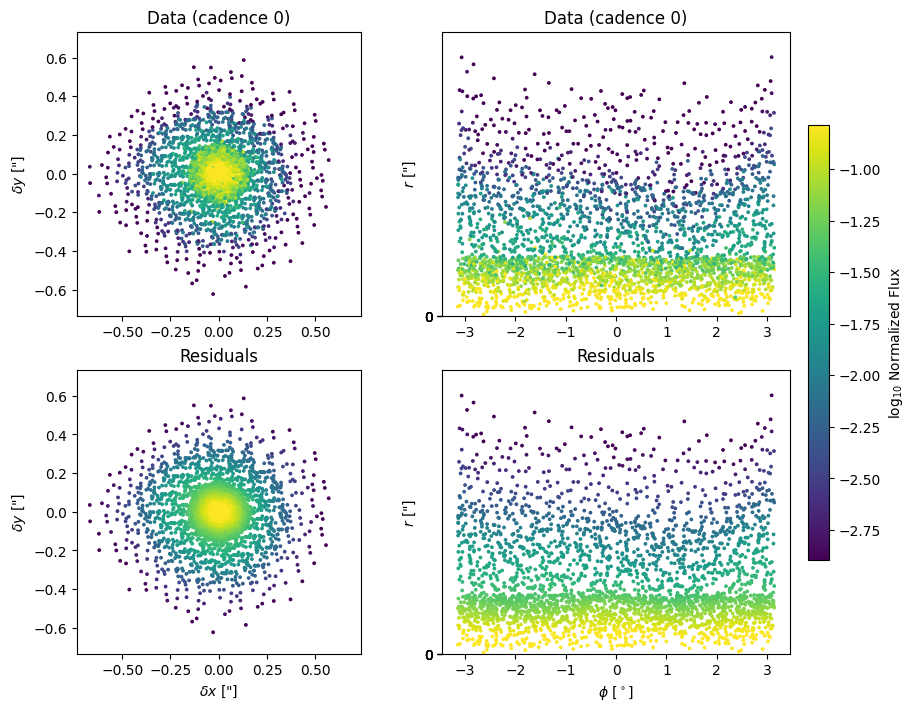

In [248]:
mac.load_shape_model("roman_WFI_ramp_F146_SCA01_shape_model_cad0.fits", flux_cut_off=0.2, plot=True, source_flux_limit=50);

In [251]:
mac.quiet = True
mac.fit_model()

Fitting 433 Sources (w. VA):   0%|                                                                  | 0/100 [00:00<?, ?it/s]/Users/jimartin/miniforge3/envs/roman/lib/python3.10/site-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)
Fitting 433 Sources (w. VA): 100%|████████████████████████████████████████████████████████| 100/100 [00:24<00:00,  4.15it/s]


In [252]:
mac.sources

index  sicbroid      column         row    F146          ra        dec  \
0       49        50   63.489769  116.298000  20.540  268.277268 -28.745779   
1       78        79    7.087752   33.925925  20.294  268.274170 -28.747054   
2      125       126   26.668413   73.090598  19.524  268.275425 -28.746337   
3      140       141    6.078032   81.631765  20.742  268.274950 -28.745799   
4      163       164   60.019046   85.345578  18.970  268.276637 -28.746530   
..     ...       ...         ...         ...     ...         ...        ...   
428  18342     18343  109.890847   84.309916  20.512  268.278121 -28.747323   
429  18372     18373   78.476191   33.082384  20.534  268.276305 -28.748172   
430  18390     18391    7.149210  123.266759  20.972  268.275690 -28.744733   
431  18422     18423   27.478701  109.797793  20.147  268.276073 -28.745395   
432  18506     18507   10.192706   91.303237  19.849  268.275238 -28.745611   

            flux   flux_err  
0     630.153958  25.102868  
1     790.399521  28.114045  
2    1606.374007  40.079596  
3     523.174621  22.873011  
4    2675.756987  51.727720  
..           ...        ...  
428   646.616330  25.428652  
429   633.645957  25.172325  
430   423.298440  20.574218  
431   904.996018  30.083152  
432  1190.821503  34.508282  

[433 rows x 9 columns]

In [253]:
mac.ws

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [209]:
mac.model_flux.shape

(100, 15625)

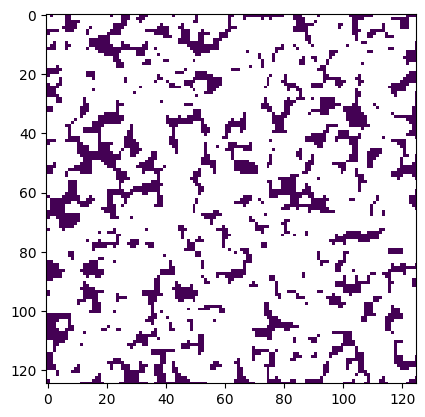

In [210]:
plt.imshow(mac.model_flux[0].reshape(mac.image_shape));

In [214]:
mac.mean_model.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

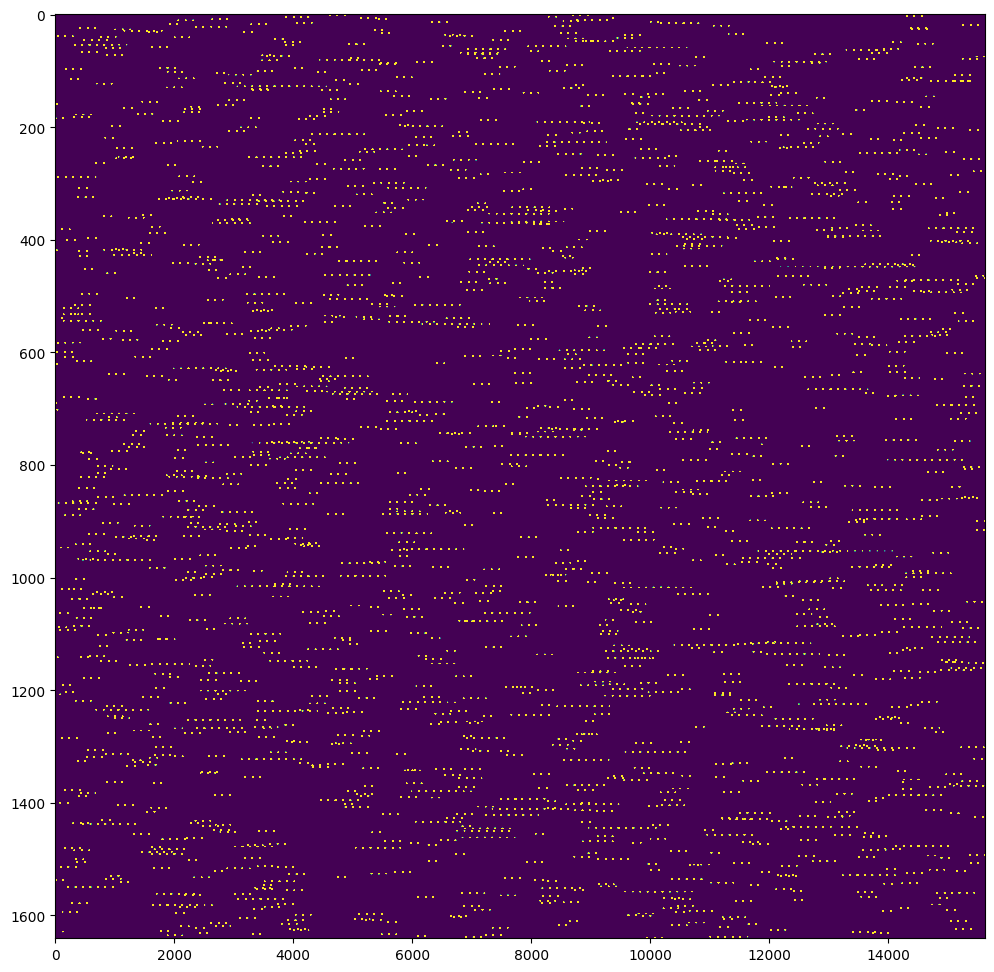

In [223]:
plt.figure(figsize=(12,12))
plt.imshow(mac.mean_model.toarray(), aspect="auto", vmin=0, vmax=0.00001);